<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/GIS582-assignments/blob/main/3AB%20-%20Analysis/3B_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 4A: Spatial interpolation and approximation I: methods

**Course:** [GIS 582 - Geospatial Modeling and Analysis](https://ncsu-geoforall-lab.github.io/geospatial-modeling-course/index.html)  
**Institution:** [NC State University, Center for Geospatial Analytics](https://cnr.ncsu.edu/geospatial/)
**Instructors:** Helena Mitasova, Corey White, and team

## Learning Objectives

In this tutorial, you will learn how to:
- Compute Voronoi polygons
- Perform IDW interpolation
- Create a DEM from contour lines
- (Optional) Create a TIN model
- (Optional) Use Python to create data for IDW comparison

## Tutorial Outline

1. [Environment Setup](##Par-1:-Environment-Setup)
2. [Compute Voronoi polygons](##-Part-2:-Compute-Voronoi-polygons)
3. [Interpolation using IDW](##-Part-3:-Interpolation-using-IDW)
4. [Compute DEM from contours](##-Part-4:-Compute-DEM-from-contours)
5. [Optional: create TIN model](##-Part-5:-Optional:-create-TIN-model)
6. [Optional: Use Python to create the data for IDW comparison](##-Part-6:-Optional:-Use-Python-to-create-the-data-for-IDW-comparison)


---
## Part 1: Environment Setup

### Install GRASS

**Important:** This setup takes 3-5 minutes. You'll need to run it each time you start a new Colab session.

In [ ]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

Check that GRASS is installed by asking which version is there.

In [ ]:
!grass --version

Check which Python version is running.

In [1]:
import sys

v = sys.version_info
print(f"We are using Python {v.major}.{v.minor}.{v.micro}")

We are using Python 3.13.2


In [2]:
import subprocess
import os
from pathlib import Path

# Ask GRASS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

In [3]:
import grass.script as gs
import grass.jupyter as gj

### Download North Carolina Sample Dataset

This dataset includes elevation, land cover, roads, streams, and more.

In [ ]:
!grass --tmp-project XY --exec g.download.project url=https://grass.osgeo.org/sampledata/north_carolina/nc_spm_08_grass7.tar.gz path=/content

### Initialize GRASS Session

In [5]:
# Start GRASS session
grassdata = "/content"
location = "~/grassdata/nc_spm_08_grass7"
mapset = "user1"  # Create a new mapset for our work

# Start GRASS Session
session = gj.init(Path(location, mapset))
print("GRASS session started.")

GRASS session started.


---
## Part 2: Compute Voronoi polygons

Display the polygons with centroids.
Find the column name where z is stored and convert the polygons to raster.
Compute aspect to evaluate the surface geometry.

Set the computational region to to `rural_1m`.

In [6]:
!g.region rural_1m -p

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Use the `v.voronoi` tool to create Voronoi polygons from the point data.

In [7]:
!v.voronoi elev_lid792_randpts output=elev_vor

Reading features...
Voronoi triangulation for 6000 points...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing edges...
Writing features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing attributes...
Searching for topology errors...
WARNING: Number of duplicate centroids: 1
Cleaning output topology
Reading features...
Snap vertices Pass 1: select points
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  9

Display the Voronoi polygons with centroids.

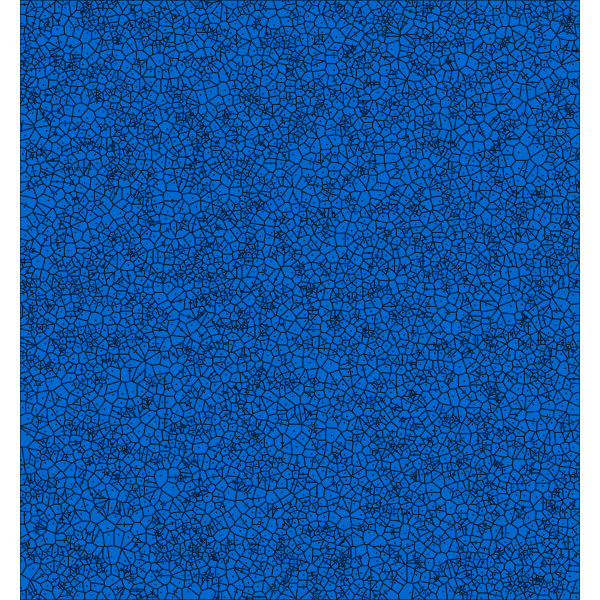

In [13]:
voronoi_map = gj.Map(height=600, width=600)
voronoi_map.d_vect(map="elev_vor", size=1, type="area,centroid")
voronoi_map.show()

Find the column name where z is stored and convert the polygons to raster.

In [15]:
!v.info -c elev_vor
!v.to.rast elev_vor output=elev_vor_1m attrcolumn=value use=attr
!r.colors elev_vor_1m color=elevation

INTEGER|cat
DOUBLE PRECISION|value
Reading areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.
Color table for raster map <elev_vor_1m> set to 'elevation'


Compute aspect to evaluate the surface geometry.

In [16]:
!r.slope.aspect elevation=elev_vor_1m aspect=asp_vor_1m

   0   0   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_vor_1m> complete


Display the resulting elevation map and aspect map.

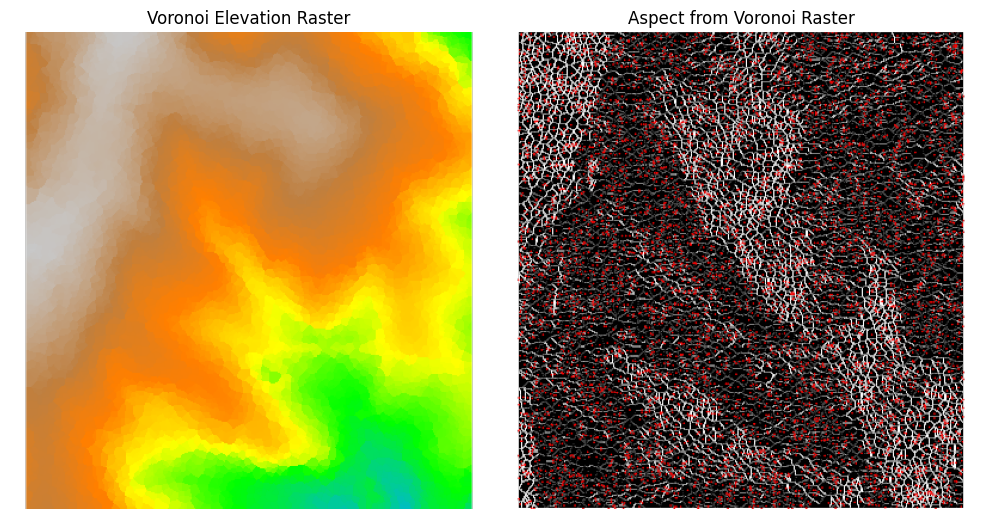

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

# Define a figure to hold the subplots
fig = plt.figure(figsize=(10, 8))
plt_gs = gridspec.GridSpec(1, 2, figure=fig)

# Create map of the evelation raster
elev_map = gj.Map(height=400, width=400)
elev_map.d_rast(map="elev_vor_1m")

# Subplot 1: Elevation Raster
ax1 = fig.add_subplot(plt_gs[0, 0])
ax1.set_title("Voronoi Elevation Raster")
ax1.imshow(Image.open(elev_map.filename))
ax1.axis("off")

# Create map of the aspect raster
asp_map = gj.Map(height=400, width=400)
asp_map.d_rast(map="asp_vor_1m")
asp_map.d_vect(map="elev_lid792_randpts", size=1, color="red", type="point")

# Subplot 2: Aspect Raster
ax2 = fig.add_subplot(plt_gs[0, 1])
ax2.set_title("Aspect from Voronoi Raster")
ax2.imshow(Image.open(asp_map.filename))
ax2.axis("off")

# Display the figure
plt.tight_layout()
plt.show()
plt.savefig("aspect_voronoi.png")

> Optional Challege: View `elev_vor_1m` in 3D perspective in the Colab Notebook. The following code will only work if you are running this notebook on your local machine.

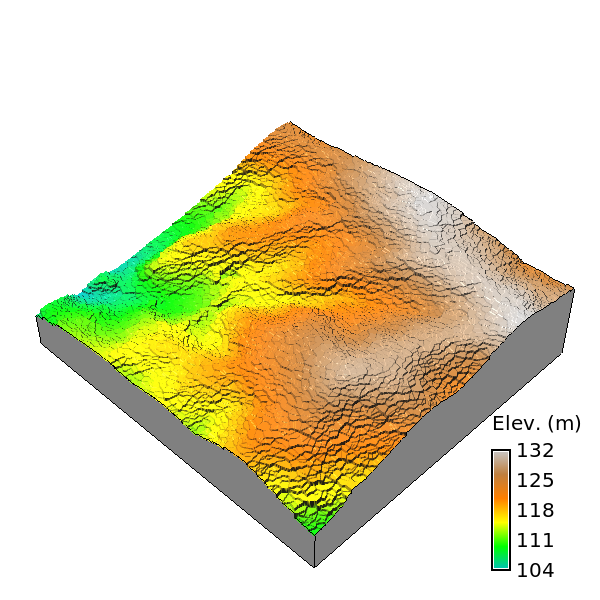

In [ ]:
# Create a 3D map of the elevation raster
elevation_3dmap = gj.Map3D(
    height=600,
    width=600,
    use_region=True,
    filename="el_vor_3d.png",
)

# Parameters for 3D rendering can be found
# at https://grass.osgeo.org/grass-stable/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="elev_vor_1m",
    color_map="elev_vor_1m",
    mode="fine",
    resolution_fine=1,
    zexag=5,
    fringe="nw,ne",
    fringe_elevation=98,
    size="600,600",
    perspective=25,
)

# Add a legend
elevation_3dmap.overlay.d_legend(
    raster="elev_vor_1m",
    at="5,25,82,85",
    title="Elev. (m)",
    font="Fira Sans Condensed Light",
    fontsize=20,
    color="black",
)

# Display the 3D map
elevation_3dmap.show()


---
## Part 3: Interpolation using IDW

Set region and resolution, find a column name where z is stored.

In [46]:
!g.region rural_1m -p
!v.info -c elev_lid792_randpts

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000
INTEGER|cat
DOUBLE PRECISION|value


Interpolate DEM using IDW, check the result using aspect.

In [47]:
!v.surf.idw elev_lid792_randpts output=elev_idw_1m column=value
!r.colors elev_idw_1m color=elevation
!r.slope.aspect elevation=elev_idw_1m aspect=asp_idw_1m

6000 points loaded
Interpolating raster map <elev_idw_1m> (750 rows, 700 columns)...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
v.surf.idw complete.
Color table for raster map <elev_idw_1m> set to 'elevation'
   0   0   0   3   9  12  15  27  30  33  36  39  42  45  48  51  54  18  21  57  60  63   6  66  24  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_idw_1m> complete


Display the results.

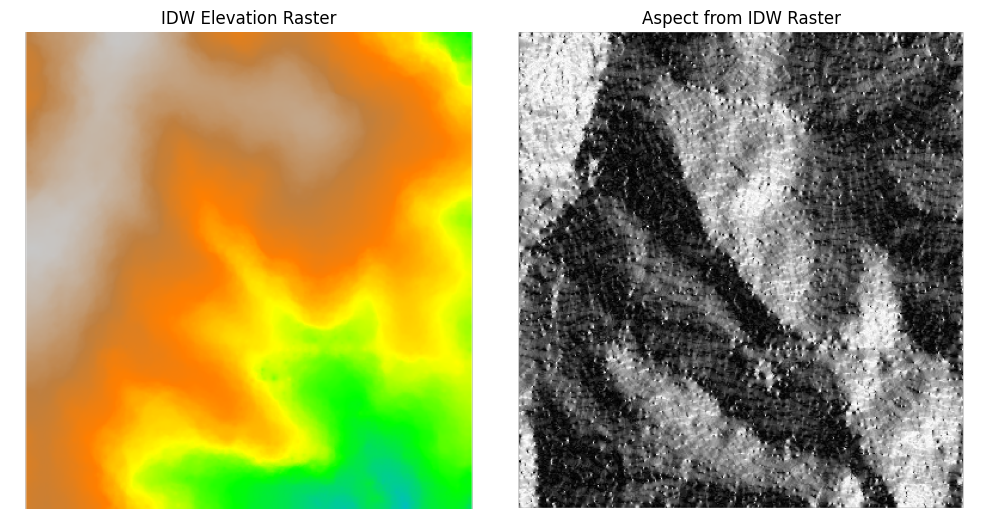

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

# Define a figure to hold the subplots
fig = plt.figure(figsize=(10, 8))
plt_gs = gridspec.GridSpec(1, 2, figure=fig)

# Create map of the evelation raster
idw_elev_map = gj.Map(height=400, width=400)
idw_elev_map.d_rast(map="elev_idw_1m")

# Subplot 1: Elevation Raster
ax1 = fig.add_subplot(plt_gs[0, 0])
ax1.set_title("IDW Elevation Raster")
ax1.imshow(Image.open(idw_elev_map.filename))
ax1.axis("off")

# Create map of the aspect raster
idw_asp_map = gj.Map(height=400, width=400)
idw_asp_map.d_rast(map="asp_idw_1m")

# Subplot 2: Aspect Raster
ax2 = fig.add_subplot(plt_gs[0, 1])
ax2.set_title("Aspect from IDW Raster")
ax2.imshow(Image.open(idw_asp_map.filename))
ax2.axis("off")

# Display the figure
plt.tight_layout()
plt.show()
plt.savefig("aspect_idw.png")

#### Task 3.1

Design experiment that elucidates the impact of IDW parameters on the surface, 
focus on the impact of **exponents** and **number of neighboring points**.

* **Exponents**
  power=0.5, 1, 5 (2 is the default)

* **Number of neighboring points**
  npoint=1, 5, 20, 60 (12 is the default)

Include selected images (e.g. hillshade or aspect) and relevant stats (e.g., mean, min, max from r.univar, histogram) that highlight the differences in the resulting surfaces into your report.

In [ ]:
# Add Task 3.1 code here

#### Task 3.2

Check the surface interpolated with default parameters using 3D view. Do not forget to switch off everything except for the interpolated elevations and set fine resolution to 1. You can use constant color for the surface to highlight its structure.

Save an image for your report.

In [ ]:
# Add Task 3.2 code here

---
## Part 4: Compute DEM from contours

Compute DEM from contours using linear interpolation between isolines:

In [49]:
!g.region rural_1m -p
!v.to.rast elev_lid792_cont1m output=el_lid792_cont1m attrcolumn=level use=attr
!r.surf.contour el_lid792_cont1m output=el_rcont
!r.colors el_rcont color=elevation

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000
Reading features...
   2   5   8  12  15  19  23  26  30  34  38  41  45  49  52  56  60  63  67  71  75  78  82  86  89  93  97 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Color table for raster map <el_rcont> set to 'elevation'


Check the result using a 2D aspect map or view el_rcont in 3D.

In [50]:
# Calculate the aspect map
!r.slope.aspect elevation=el_rcont aspect=asp_rcont

   0   0   3   6   9  12  15  18  21  24  27  33  42  45  48  36  30  39  51  54  57  60  63  66  69  72  75  78  81  87  84  90  93  96  99 100
Aspect raster map <asp_rcont> complete


#### Task 4.1

Display the 2D aspect map

Here is the bash code to do this:

```bash
d.rast el_rcont
d.rast asp_rcont
d.vect elev_lid792_cont1m col=white
d.out.file asp_rcont
```

Please use `grass.jupyter` to display the maps in the notebook cell below. Make sure to save the image as `asp_rcont.png`.

In [ ]:
# Add you code here

#### Task 4.2

Display the 3D view of `el_rcont` save the image as `asp_rcont_3d.png`.

> Hint: In 3D set view from SE and light from NW to reveal subtle geometry.

In [ ]:
# Add code here

---
## Part 5: Optional create TIN model

Convert z-value stored as attribute "value" to z-coordinate.
Compute TIN:

In [51]:
!v.to.3d elev_lid792_randpts output=elev_lid792_randpts3d column=value
!v.delaunay elev_lid792_randpts3d output=elev_rand_tin
!v.colors elev_rand_tin use=z color=elevation
!r.mapcalc "level90 = 90"

Fetching height from <value> column...
Transforming features...
Copying attributes... 30      40      50      60
Building topology for vector map <elev_lid792_randpts3d@user1>...
Registering primitives...
Vertical extent of vector map <elev_lid792_randpts3d>: B: 103.969032 T:
131.528778
Reading point features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing edges...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Building topology for vector map <elev_rand_tin@user1>...
Registering primitives...
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Calculating area centroids...
   2   5   8  11  14  17  20  23  26  29  32  35  38  

#### Task 5.1

Visualize the TIN as 3D vector data:

* Use layers `level90` and `elev_rand_tin`
* Set the vector line color to `gray`

In [ ]:
# Add code here

## Part 6: Optional: Use Python to create the data for IDW comparison

A part of the first interpolation assignment (4A) for GRASS is computing IDW with different parameters. The task is to compare the different results in any way you think is appropriate and comment on the results. To comment on the results, you need to create them. You can simply execute the module with different parameters and then compute all the subsequent analyses which will help you determine what are the properties of the surfaces generated by IDW with different settings. However, you can also use Python to compute this data if you know Python at least a little bit.
The good new is you can write your GRASS scripts in Python and execute them in the notebook. You can also use Python to compute statistics and create visualizations for your report.

The way to call GRASS modules in Python is very similar to what we use in the assignments and it is described in the documentation. The page also contains several examples how to write simple and more advanced scripts. Here are some examples relevant to the assignment.

#### Example 1

Interpolation using different number of points (modify the list of numbers of points):

In [52]:
import grass.script as gs

for npoints in [1, 20]:
    name = "elev_idw_1m_npoints_{}".format(npoints)
    stats = gs.parse_command(
        "v.surf.idw",
        input="elev_lid792_randpts",
        output=name,
        column="value",
        npoints=npoints,
    )


#### Example 2

Computing statistics but showing only some for different number of points (you can combine the code with the code above):

In [ ]:
import grass.script as gs

for npoints in [1, 20]:
    name = f"elev_idw_1m_npoints_{npoints}"
    print("\n")
    print(name)
    print(len(name) * "=")
    stats = gs.parse_command("r.univar", map=name, flags="eg")

    print(stats["min"], stats["max"])




elev_idw_1m_npoints_1
103.969032 131.528778


elev_idw_1m_npoints_20
103.969032 131.528778


#### Task 6.1

Now write your own code to compute IDW interpolation for different values of `power` parameter (e.g., 0.5, 1, 2, 5) by modifying the previous code. Once you have the `elev_idw_1m_power_05`, .... computed you can set the color table and compute shaded relief for your outputs:

In [ ]:
import grass.script as gs

for power in [0.5, 1, 2, 5]:
    gs.run_command(
        "r.colors", map=f"elev_idw_1m_power_{power}", color="elevation"
    )
    gs.run_command(
        "r.relief",
        input=f"elev_idw_1m_power_{power}",
        output=f"elev_idw_1m_power_{power}_relief",
    )
    gs.run_command(
        "r.shade",
        color=f"elev_idw_1m_power_{power}",
        shade=f"elev_idw_1m_power_{power}_relief",
        output=f"elev_idw_1m_power_{power}_shaded",
    )

Creating a PNG image with histogram for changing power:

In [ ]:
import grass.script as gs

for power in [0.5, 1, 2, 5]:
    m = gj.Map(height=400, width=400, filename=f"elev_idw_1m_power_{power}_histogram.png")
    m.d_histogram(
        map=f"elev_idw_1m_power_{power}", size=2, color="blue"
    )
    m.show()


Here are two commands often used when using the scripts. First is setting the computational. We can do that in a script, but it better and more general to do it before executing the script:

```python
gs.run_command("g.region", region="rural_1m")
```

When we want to run the script again, we first need to remove the created raster maps:

```python
gs.run_command("g.remove", type="raster", pattern="elev_idw_1m_npoints_*")
```

In case you don't know anything about Python scripting but you still want to try something this might be a good start together with some (free) courses at [Codecademy](https://www.codecademy.com/). To learn more about using Python in GRASS, see the [grass.script package](https://grass.osgeo.org/grass-devel/manuals/libpython/script_intro.html).

Note: In GRASS 8.5 the [`grass.tools` package](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.tools.html) is being introduced as a replacement for `grass.script`. The new package provides a more intuitive interface to learn more see the [GRASS Introduction to Python](https://grass.osgeo.org/grass85/manuals/python_intro.html) in the GRASS 8.5 documentation.


```python
import sys
import subprocess

# Append GRASS to the python system path
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

import grass.script as gs
from grass.tools import Tools

# Create a new project
gs.create_project(path="path/to/my_project", epsg="3358")

# Initialize the GRASS session
with gs.setup.init("path/to/my_project") as session:

    # Run GRASS tools
    tools = Tools(session=session)
    tools.r_import_(input="/path/to/elevation.tif", output="elevation")
    tools.g_region(raster="elevation")
    tools.r_slope_aspect(elevation="elevation", slope="slope")
```